In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from load_data import my_conn
from load_data.db_model.activity import Activity
from load_data.db_model.sensor_data import SensorData
from load_data.db_model.session import Session
from sqlalchemy import func

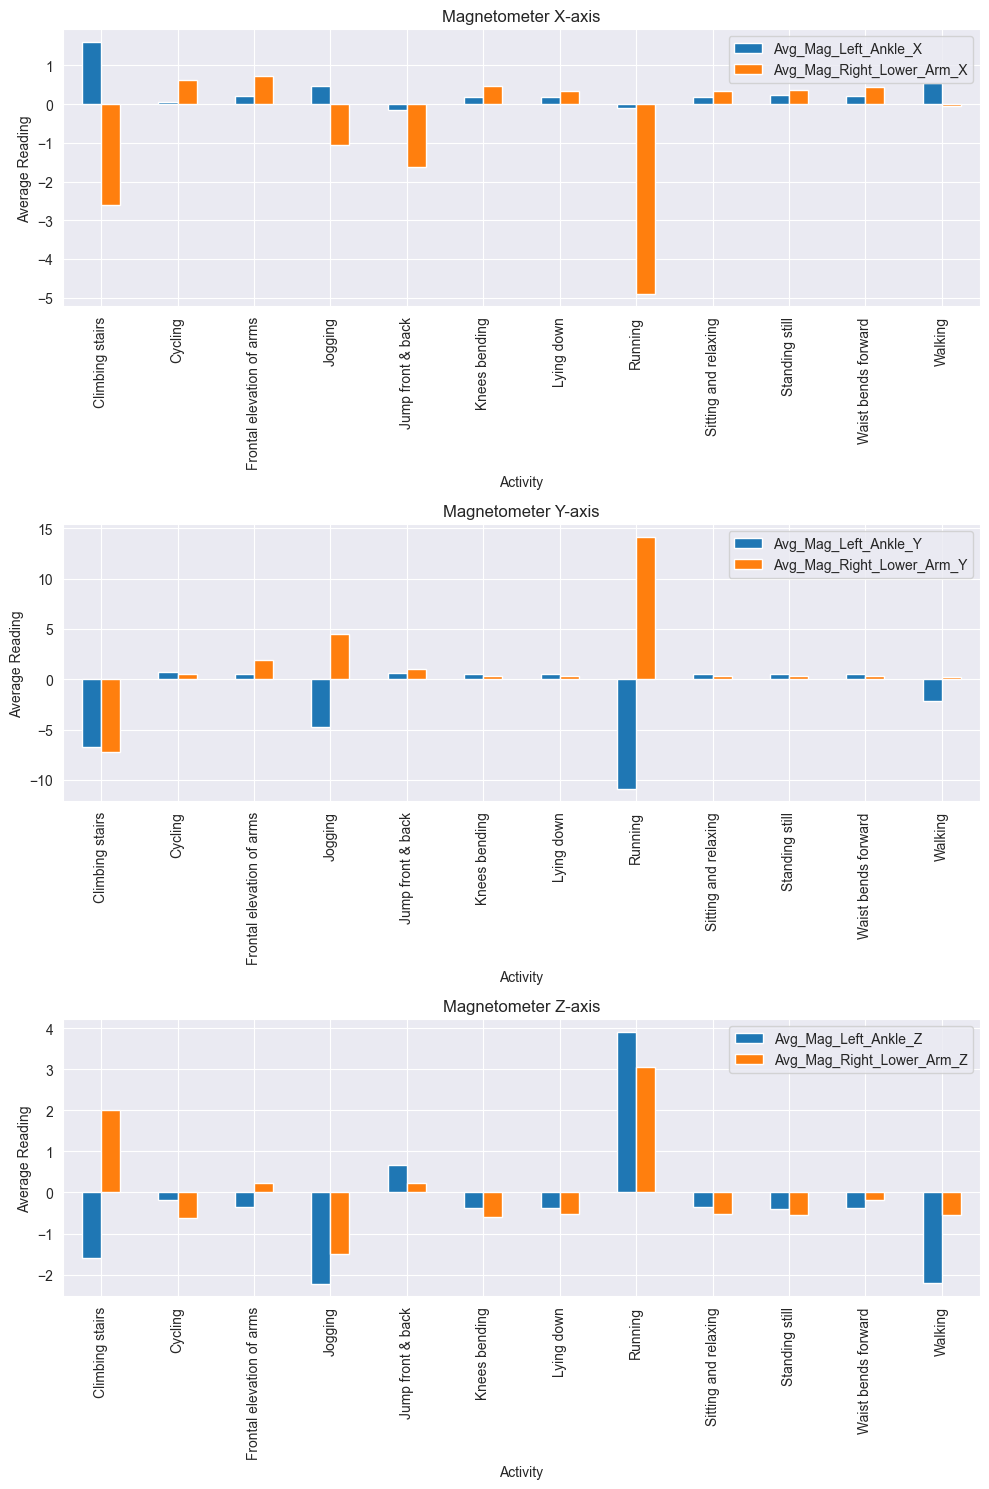

In [20]:
db = my_conn.load_db()

query = (
    db.query(
        Activity.description,
        func.avg(SensorData.magnetometer_left_ankle_x),
        func.avg(SensorData.magnetometer_left_ankle_y),
        func.avg(SensorData.magnetometer_left_ankle_z),
        func.avg(SensorData.magnetometer_right_lower_arm_x),
        func.avg(SensorData.magnetometer_right_lower_arm_y),
        func.avg(SensorData.magnetometer_right_lower_arm_z),
    )
    .join(Session, Session.id == SensorData.session_id)
    .join(Activity, Activity.id == Session.activity_id)
    .group_by(Activity.description)
    .all()
)

db.close()

df = pd.DataFrame(
    query,
    columns=[
        "Activity",
        "Avg_Mag_Left_Ankle_X",
        "Avg_Mag_Left_Ankle_Y",
        "Avg_Mag_Left_Ankle_Z",
        "Avg_Mag_Right_Lower_Arm_X",
        "Avg_Mag_Right_Lower_Arm_Y",
        "Avg_Mag_Right_Lower_Arm_Z",
    ],
)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

df.plot(
    x="Activity",
    y=["Avg_Mag_Left_Ankle_X", "Avg_Mag_Right_Lower_Arm_X"],
    kind="bar",
    ax=axes[0],
    title="Magnetometer X-axis",
)
axes[0].set_ylabel("Average Reading")

# Y-axis
df.plot(
    x="Activity",
    y=["Avg_Mag_Left_Ankle_Y", "Avg_Mag_Right_Lower_Arm_Y"],
    kind="bar",
    ax=axes[1],
    title="Magnetometer Y-axis",
)
axes[1].set_ylabel("Average Reading")

# Z-axis
df.plot(
    x="Activity",
    y=["Avg_Mag_Left_Ankle_Z", "Avg_Mag_Right_Lower_Arm_Z"],
    kind="bar",
    ax=axes[2],
    title="Magnetometer Z-axis",
)
axes[2].set_ylabel("Average Reading")


plt.tight_layout()
plt.show()

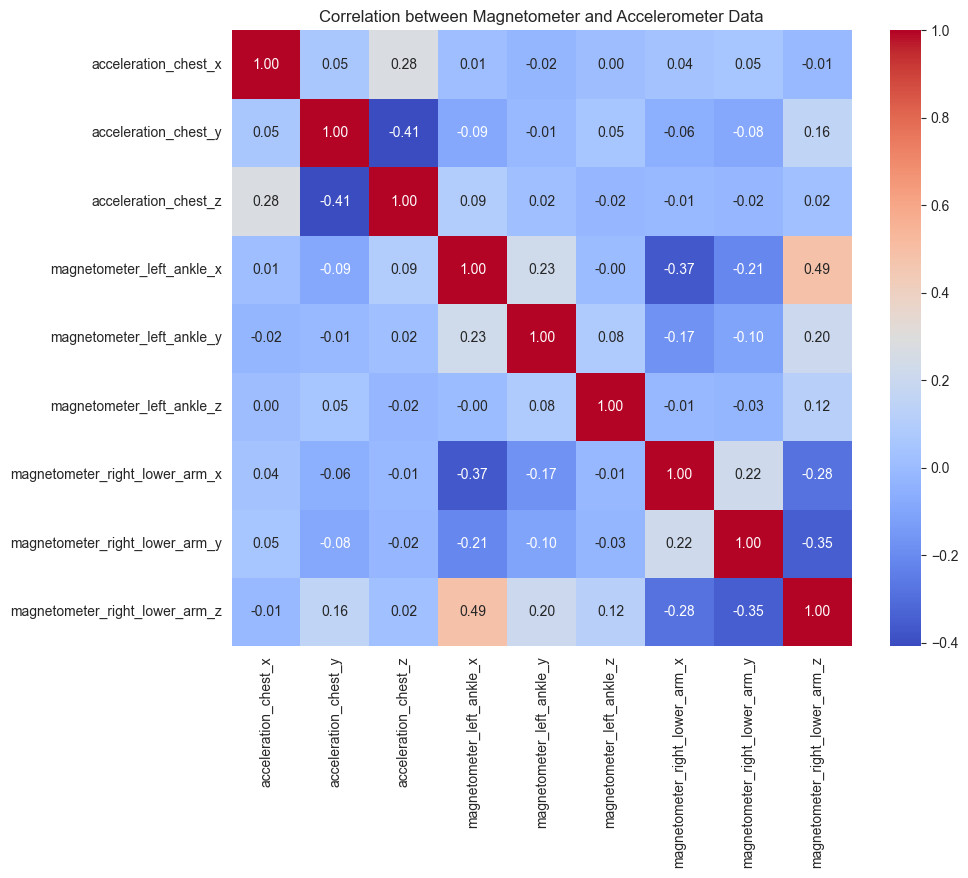

In [24]:
db_session = db
sensor_data_query = (
    db_session.query(
        SensorData.acceleration_chest_x,
        SensorData.acceleration_chest_y,
        SensorData.acceleration_chest_z,
        SensorData.magnetometer_left_ankle_x,
        SensorData.magnetometer_left_ankle_y,
        SensorData.magnetometer_left_ankle_z,
        SensorData.magnetometer_right_lower_arm_x,
        SensorData.magnetometer_right_lower_arm_y,
        SensorData.magnetometer_right_lower_arm_z,
    )
    .join(Session, Session.id == SensorData.session_id)
    .all()
)
db_session.close()

sensor_data = pd.DataFrame(sensor_data_query)

correlation_matrix = sensor_data.corr()

# Use seaborn to create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation between Magnetometer and Accelerometer Data")
plt.show()

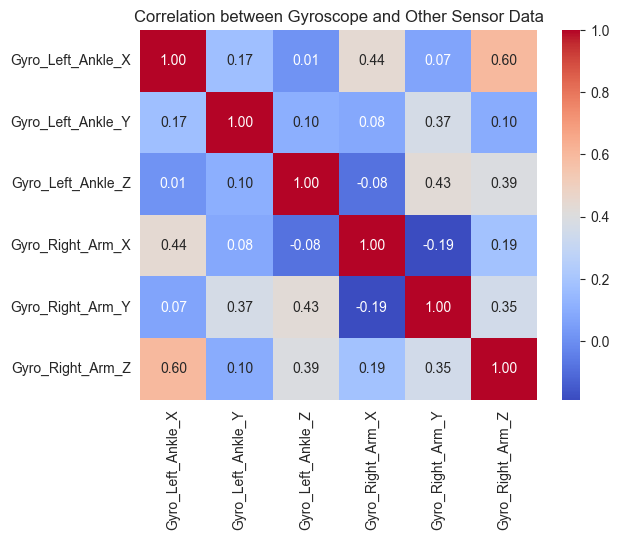

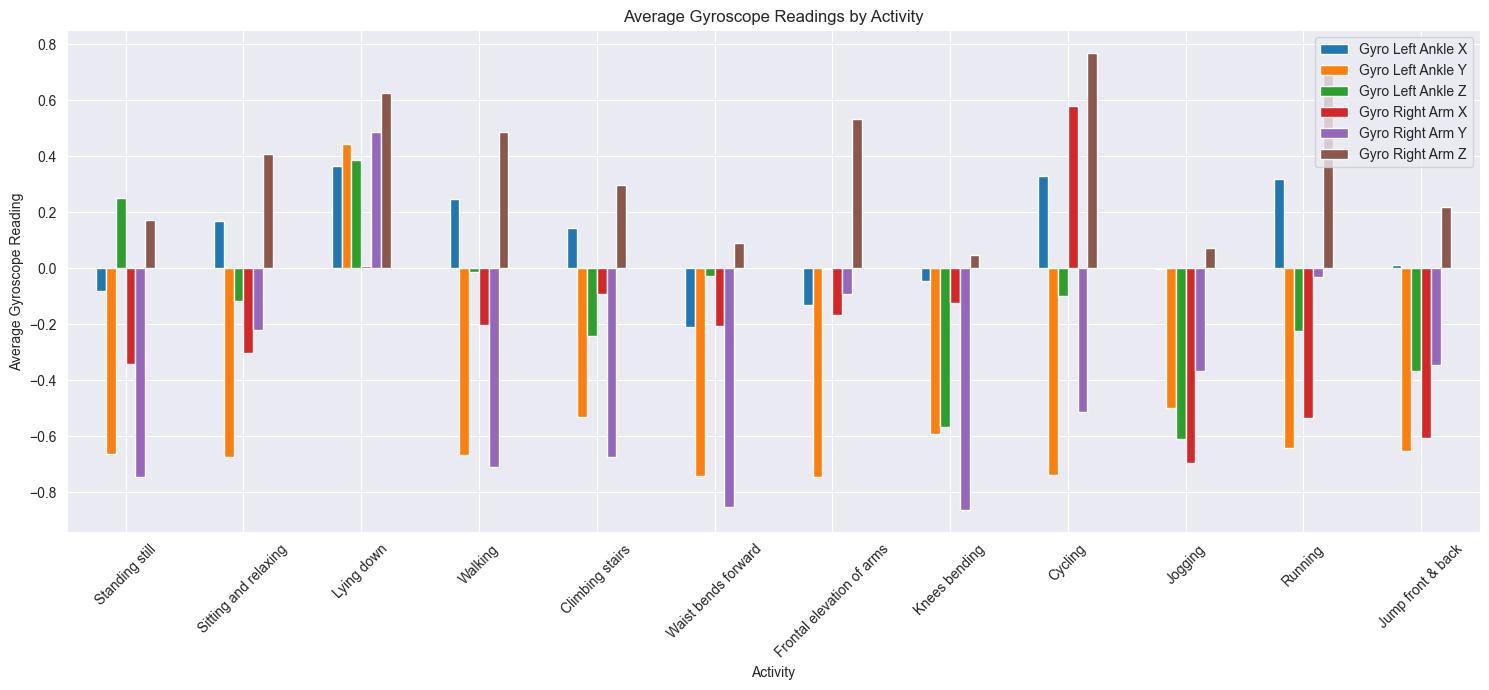

In [30]:
gyroscope_query = (
    db_session.query(
        SensorData.acceleration_chest_x,
        SensorData.acceleration_chest_y,
        SensorData.acceleration_chest_z,
        SensorData.gyro_left_ankle_x,
        SensorData.gyro_left_ankle_y,
        SensorData.gyro_left_ankle_z,
        SensorData.gyro_right_lower_arm_x,
        SensorData.gyro_right_lower_arm_y,
        SensorData.gyro_right_lower_arm_z,
        Activity.id,
        Activity.description,
    )
    .join(Session, Session.id == SensorData.session_id)
    .join(Activity, Activity.id == Session.activity_id)
    .order_by(Activity.id)
    .all()
)

db_session.close()


df_gyroscope = pd.DataFrame(
    gyroscope_query,
    columns=[
        "Acc_Chest_X",
        "Acc_Chest_Y",
        "Acc_Chest_Z",
        "Gyro_Left_Ankle_X",
        "Gyro_Left_Ankle_Y",
        "Gyro_Left_Ankle_Z",
        "Gyro_Right_Arm_X",
        "Gyro_Right_Arm_Y",
        "Gyro_Right_Arm_Z",
        "Activity_ID",
        "Activity_Description",
    ],
)

correlation_matrix = df_gyroscope.iloc[:, :-2].corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation between Gyroscope and Accelerometer Data")
plt.show()

avg_gyroscope_by_activity = df_gyroscope.groupby(
    ["Activity_ID", "Activity_Description"]
).mean()

avg_gyroscope_by_activity = avg_gyroscope_by_activity.reset_index()

ax = avg_gyroscope_by_activity.plot(
    x="Activity_Description",
    y=[
        "Gyro_Left_Ankle_X",
        "Gyro_Left_Ankle_Y",
        "Gyro_Left_Ankle_Z",
        "Gyro_Right_Arm_X",
        "Gyro_Right_Arm_Y",
        "Gyro_Right_Arm_Z",
    ],
    kind="bar",
    figsize=(15, 7),
)

plt.title("Average Gyroscope Readings by Activity")
plt.xlabel("Activity")
plt.ylabel("Average Gyroscope Reading")

plt.xticks(rotation=45)

plt.legend(
    [
        "Gyro Left Ankle X",
        "Gyro Left Ankle Y",
        "Gyro Left Ankle Z",
        "Gyro Right Arm X",
        "Gyro Right Arm Y",
        "Gyro Right Arm Z",
    ],
    loc="upper right",
)

plt.tight_layout()
plt.show()